# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<u><b>Признаки</b></u><br>

<i><b>DateCrawled</b></i> — дата скачивания анкеты из базы<br>
<i><b>VehicleType</b></i> — тип автомобильного кузова<br>
<i><b>RegistrationYear</b></i> — год регистрации автомобиля<br>
<i><b>Gearbox</b></i> — тип коробки передач<br>
<i><b>Power</b></i> — мощность (л. с.)<br>
<i><b>Model</b></i> — модель автомобиля<br>
<i><b>Kilometer</b></i> — пробег (км)<br>
<i><b>RegistrationMonth</b></i> — месяц регистрации автомобиля<br>
<i><b>FuelType</b></i> — тип топлива<br>
<i><b>Brand</b></i> — марка автомобиля<br>
<i><b>NotRepaired</b></i> — была машина в ремонте или нет<br>
<i><b>DateCreated</b></i> — дата создания анкеты<br>
<i><b>NumberOfPictures</b></i> — количество фотографий автомобиля<br>
<i><b>PostalCode</b></i> — почтовый индекс владельца анкеты (пользователя)<br>
<i><b>LastSeen</b></i> — дата последней активности пользователя<br>

<u><b>Целевой признак</b></u><br>

<i><b>Price</b></i> — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import time

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor

In [2]:
def data_read(file_path):
    data = pd.read_csv(file_path)
    data.columns = data.columns.str.lower()
    display(data.head())
    display(data.info())
    display('Количество пропусков:', data.isna().sum())
    display('Количество дубликатов:', sum(data.duplicated()))
    display(data.describe())
    return data

In [3]:
data = data_read('/datasets/autos.csv')

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
datecrawled          354369 non-null object
price                354369 non-null int64
vehicletype          316879 non-null object
registrationyear     354369 non-null int64
gearbox              334536 non-null object
power                354369 non-null int64
model                334664 non-null object
kilometer            354369 non-null int64
registrationmonth    354369 non-null int64
fueltype             321474 non-null object
brand                354369 non-null object
notrepaired          283215 non-null object
datecreated          354369 non-null object
numberofpictures     354369 non-null int64
postalcode           354369 non-null int64
lastseen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


None

'Количество пропусков:'

datecrawled              0
price                    0
vehicletype          37490
registrationyear         0
gearbox              19833
power                    0
model                19705
kilometer                0
registrationmonth        0
fueltype             32895
brand                    0
notrepaired          71154
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

'Количество дубликатов:'

4

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Для начала гляну на дубликаты, так как их мало.

In [4]:
data[data.duplicated()]

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [5]:
data.drop_duplicates(inplace=True)

Проверим что пишут в столбцах с пропусками.

In [6]:
display(data['vehicletype'].unique())
display(data['gearbox'].unique())
display(data['model'].unique())
display(data['fueltype'].unique())
display(data['notrepaired'].unique())

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

array(['manual', 'auto', nan], dtype=object)

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

array([nan, 'yes', 'no'], dtype=object)

Что мы имеем:<br>

<b>Тип кузова</b> - можем подставить по модели.<br>
<b>Коробка передач</b> - аналогично, по модели, но есть нюанс - много вариантов авто есть с двумя видами передач. То что не заполнится, придется дропать.<br>
<b>Модель</b> - по марке авто и кузову.<br>
<b>Тип топлива</b> - скорее всего тоже по модели, но очень интересно что за тип "другой".<br>
<b>Ремонт</b> - скорее всего пропущено там, где ремонта не было.

In [7]:
# Просто посмотреть какой-то пример
data.query('model == "golf"').groupby('vehicletype')['vehicletype'].count()

vehicletype
bus              760
convertible     1962
coupe            429
other            185
sedan          14744
small           3911
suv               25
wagon           3181
Name: vehicletype, dtype: int64

Я думаю надо поступить так:
- Заполняем ремонт логической заменой.
- Находим полный мусор, где все столбцы пропущены (ремонт не в счет). Это подлежит удалению.
- Топливо и кп самые неприятные. Можно заполнить по самым предпочитаемым, можно удалить вовсе, а можно удалить там где остутствует кузов.
- Надо заполнить модели по бренду.
- Далее заполняем кузова по моделям.

In [8]:
data['notrepaired'].fillna('yes', inplace=True)

In [9]:
data.query('vehicletype.isna()==True & gearbox.isna()==True & model.isna()==True & fueltype.isna()==True')

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
306,2016-03-21 14:38:37,200,NaN,2009,NaN,0,NaN,10000,0,NaN,sonstige_autos,yes,2016-03-21 00:00:00,0,6493,2016-03-24 02:47:34
522,2016-03-14 18:40:14,0,NaN,2000,NaN,0,NaN,150000,0,NaN,volvo,yes,2016-03-14 00:00:00,0,25524,2016-03-14 18:40:14
538,2016-03-15 17:43:21,2600,NaN,2005,NaN,0,NaN,125000,0,NaN,chevrolet,yes,2016-03-15 00:00:00,0,94315,2016-04-06 14:45:44
552,2016-03-21 10:52:52,50,NaN,1985,NaN,0,NaN,150000,11,NaN,trabant,yes,2016-03-21 00:00:00,0,69120,2016-03-22 14:50:41
622,2016-03-16 16:55:09,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,yes,2016-03-16 00:00:00,0,44628,2016-03-20 16:44:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353727,2016-03-20 17:56:59,1,NaN,2000,NaN,0,NaN,150000,0,NaN,bmw,yes,2016-03-20 00:00:00,0,42329,2016-04-07 00:46:36
354073,2016-03-19 14:53:26,1750,NaN,1995,NaN,0,NaN,100000,12,NaN,sonstige_autos,yes,2016-03-19 00:00:00,0,6188,2016-04-01 01:47:17
354083,2016-03-30 07:54:17,0,NaN,2000,NaN,0,NaN,150000,0,NaN,sonstige_autos,yes,2016-03-30 00:00:00,0,6686,2016-04-06 23:46:19
354162,2016-03-07 19:51:14,1500,NaN,1995,NaN,0,NaN,150000,0,NaN,volkswagen,yes,2016-03-07 00:00:00,0,26789,2016-04-03 11:46:59


In [10]:
data.dropna(subset=['vehicletype','model','gearbox','fueltype'], how='all', inplace=True)

In [11]:
def fil(fromm, where):
    try:
        temp = data[where].isna().sum()
        data[where] = data[where].fillna(data.groupby(fromm)[where].transform(lambda x: x.mode()[0]))
        print('Заполнили {} пропусков!'.format(temp))
    except:
        print('Где-то есть нестыковки, заполнить не выйдет')
        data.dropna(subset=[where], inplace=True)
        print('Удалено {} пропусков!'.format(temp))

In [12]:
fil('brand','model')

Где-то есть нестыковки, заполнить не выйдет
Удалено 17313 пропусков!


Скорее всего в пропусках есть бренд, которого нет в строках с заполненной моделью.

In [13]:
fil('model','vehicletype')

Заполнили 30662 пропусков!


In [14]:
fil('vehicletype','fueltype')

Заполнили 25732 пропусков!


In [15]:
fil('vehicletype','gearbox')

Заполнили 15702 пропусков!


In [16]:
display(data.isna().sum())
data.info()

datecrawled          0
price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
kilometer            0
registrationmonth    0
fueltype             0
brand                0
notrepaired          0
datecreated          0
numberofpictures     0
postalcode           0
lastseen             0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334660 entries, 0 to 354368
Data columns (total 16 columns):
datecrawled          334660 non-null object
price                334660 non-null int64
vehicletype          334660 non-null object
registrationyear     334660 non-null int64
gearbox              334660 non-null object
power                334660 non-null int64
model                334660 non-null object
kilometer            334660 non-null int64
registrationmonth    334660 non-null int64
fueltype             334660 non-null object
brand                334660 non-null object
notrepaired          334660 non-null object
datecreated          334660 non-null object
numberofpictures     334660 non-null int64
postalcode           334660 non-null int64
lastseen             334660 non-null object
dtypes: int64(7), object(9)
memory usage: 43.4+ MB


У нас в начальной информации были видны выбросы. Посмотрим что изменилось.

In [17]:
data.describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,334660.000000,334660.000000,334660.000000,334660.000000,334660.000000,334660.0,334660.000000
mean,4504.372249,2003.924024,111.372659,128562.795076,5.806075,0.0,50671.327365
std,4531.457109,69.377633,185.157391,37205.638630,3.689157,0.0,25754.527341
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1150.000000,1999.000000,70.000000,125000.000000,3.000000,0.0,30419.000000
50%,2800.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49525.000000
75%,6500.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71229.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В основном ничего.<br>
Даты тут наверное совсем не надо, они не несут информации. Важные выбросы в цене и мощности.

In [18]:
dat = data.copy()

In [19]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334660 entries, 0 to 354368
Data columns (total 16 columns):
datecrawled          334660 non-null object
price                334660 non-null int64
vehicletype          334660 non-null object
registrationyear     334660 non-null int64
gearbox              334660 non-null object
power                334660 non-null int64
model                334660 non-null object
kilometer            334660 non-null int64
registrationmonth    334660 non-null int64
fueltype             334660 non-null object
brand                334660 non-null object
notrepaired          334660 non-null object
datecreated          334660 non-null object
numberofpictures     334660 non-null int64
postalcode           334660 non-null int64
lastseen             334660 non-null object
dtypes: int64(7), object(9)
memory usage: 43.4+ MB


In [20]:
dat.drop(['datecrawled','registrationyear','registrationmonth','datecreated','numberofpictures','postalcode','lastseen'],
         axis=1, inplace=True)

In [21]:
wh_area0 = (dat['price'].quantile(0.75) - dat['price'].quantile(0.25))*1.5
q1 = dat['price'].quantile(0.25) - wh_area0
q2 = dat['price'].quantile(0.75) + wh_area0
print(q1, q2)
display(dat.query('price < @q1 | price > @q2').count())
dat[dat['price']==0]

-6875.0 14525.0


price          17252
vehicletype    17252
gearbox        17252
power          17252
model          17252
kilometer      17252
fueltype       17252
brand          17252
notrepaired    17252
dtype: int64

,price,vehicletype,gearbox,power,model,kilometer,fueltype,brand,notrepaired
7,0,sedan,manual,50,other,40000,petrol,volkswagen,no
40,0,small,manual,0,corsa,150000,petrol,opel,yes
111,0,sedan,manual,0,golf,5000,petrol,volkswagen,yes
152,0,bus,manual,101,meriva,150000,lpg,opel,yes
154,0,sedan,manual,0,other,5000,petrol,fiat,yes
...,...,...,...,...,...,...,...,...,...
354205,0,small,manual,65,corsa,150000,petrol,opel,yes
354238,0,small,manual,60,fiesta,150000,petrol,ford,yes
354248,0,small,manual,53,swift,150000,petrol,suzuki,yes
354277,0,small,manual,37,arosa,150000,petrol,seat,yes


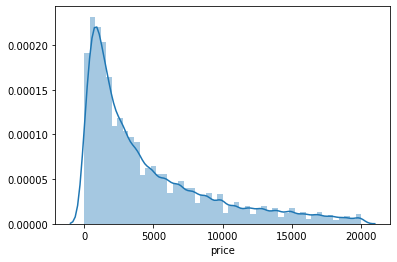

In [22]:
sns.distplot(dat['price'])

Влево, да еще как. Я считаю что надо убрать авто с прайсом 0, а затем верхний выброс. Но лучше снова проверить после удаления нулей.

In [23]:
dat.drop(dat[dat['price']==0].index, inplace=True)

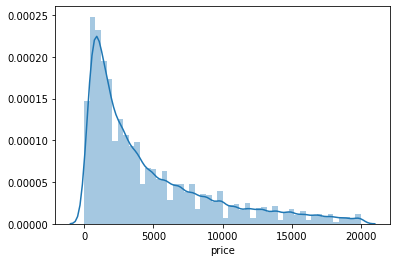

In [24]:
sns.distplot(dat['price'])

Фактически без изменений. Неприятные значения, пока просто глянем что там.

In [25]:
dat.query('price < 100')['price'].sort_values().value_counts()

1     936
50    277
80    125
99     93
10     69
70     63
60     50
75     47
30     46
20     37
40     37
90     31
15     22
5      21
55     20
25     19
35     17
45     16
65     15
95     11
2      10
85      8
13      6
9       6
49      6
59      5
17      5
12      5
3       5
14      4
39      4
79      4
89      3
11      3
18      3
69      2
19      2
66      2
98      2
29      2
7       2
38      1
32      1
47      1
26      1
58      1
77      1
33      1
16      1
74      1
27      1
21      1
8       1
24      1
Name: price, dtype: int64

In [26]:
dat.drop(dat[dat['price']<100].index, inplace=True)

In [27]:
# уберем пока верхние выбросы
dat.drop(dat[dat['price'] > 14525].index, inplace=True)

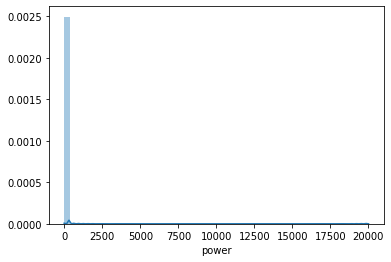

In [28]:
sns.distplot(dat['power'])

In [29]:
dat.describe()

,price,power,kilometer
count,306766.000000,306766.000000,306766.000000
mean,3955.662635,108.538283,130687.527301
std,3523.890776,184.191600,35119.423363
min,100.000000,0.000000,5000.000000
25%,1200.000000,69.000000,125000.000000
50%,2750.000000,102.000000,150000.000000
75%,5900.000000,140.000000,150000.000000
max,14525.000000,20000.000000,150000.000000


In [30]:
wh_area1 = (dat['power'].quantile(0.75) - dat['power'].quantile(0.25))*1.5
qp1 = dat['power'].quantile(0.25) - wh_area1
qp2 = dat['power'].quantile(0.75) + wh_area1
print(qp1, qp2)
display(dat.query('power < @qp1 | power > @qp2').count())
dat[dat['power']==0]

-37.5 246.5


price          5266
vehicletype    5266
gearbox        5266
power          5266
model          5266
kilometer      5266
fueltype       5266
brand          5266
notrepaired    5266
dtype: int64

,price,vehicletype,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,480,sedan,manual,0,golf,150000,petrol,volkswagen,yes
15,450,small,manual,0,ka,5000,petrol,ford,yes
32,245,sedan,manual,0,golf,150000,petrol,volkswagen,no
37,1500,bus,manual,0,kangoo,150000,gasoline,renault,no
54,4700,wagon,manual,0,signum,150000,gasoline,opel,no
...,...,...,...,...,...,...,...,...,...
354332,7900,bus,manual,0,b_klasse,125000,petrol,mercedes_benz,no
354335,390,small,auto,0,corsa,100000,petrol,opel,yes
354336,3299,suv,auto,0,outlander,150000,petrol,mitsubishi,yes
354346,2600,sedan,auto,0,c_klasse,150000,petrol,mercedes_benz,yes


Как мы видим, с нулем мощности идут авто с большим километражом (кроме частных случаев), требующие капремонта. Мне кажется это актуальные значения и их нельзя удалять.

In [31]:
dat.drop(dat[dat['power'] > 246.5].index, inplace=True)

In [32]:
dat.reset_index(inplace=True, drop=True)

## Обучение моделей

In [33]:
state = np.random.RandomState(0)

In [34]:
encoder = OrdinalEncoder()
dat[['vehicletype','gearbox','model','fueltype','brand','notrepaired']] =pd.DataFrame(
    encoder.fit_transform(dat[['vehicletype','gearbox','model','fueltype','brand','notrepaired']]))
dat.head(5)

,price,vehicletype,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,480,4.0,1.0,0,116.0,150000,6.0,37.0,1.0
1,9800,6.0,0.0,163,117.0,125000,2.0,14.0,1.0
2,1500,5.0,1.0,75,116.0,150000,6.0,37.0,0.0
3,3600,5.0,1.0,69,101.0,90000,2.0,31.0,0.0
4,650,4.0,1.0,102,11.0,150000,6.0,2.0,1.0


In [35]:
features = dat.drop(['price'], axis = 1)
target = dat['price']

features_train, features_x, target_train, target_x = train_test_split(
    features, target, test_size=0.4, random_state=state)

features_test, features_valid, target_test, target_valid = train_test_split(
    features_x, target_x, test_size=0.5, random_state=state)

In [36]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train = pd.DataFrame(scaler.transform(features_train), columns=features_train.columns, index=features_train.index)
features_valid = pd.DataFrame(scaler.transform(features_valid), columns=features_valid.columns, index=features_valid.index)
features_test = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns, index=features_test.index)

In [37]:
score_func = make_scorer(mse, greater_is_better=False)

In [38]:
def predict(model, features, target):
    start_time = time.time()
    pred = model.predict(features)
    print('Время предсказания', time.time() - start_time)
    rmse = mse(target, pred)**0.5
    print('RMSE =', rmse)

In [39]:
start_time = time.time()

linreg = LinearRegression().fit(features_train, target_train)

print('Время обучения ', time.time() - start_time)

predict(linreg, features_valid, target_valid)

Время обучения  0.039986610412597656
Время предсказания 0.038378000259399414
RMSE = 2600.4663818001336


In [40]:
rfr = RandomForestRegressor

param_rfr = { 'n_estimators': range (10, 31, 10)#,
              #'max_depth': range (1, 10, 1),
              #'min_samples_leaf': range (1,5),
              #'min_samples_split': range (2,5) 
            }


grid_rfr = GridSearchCV(rfr(random_state=state), param_rfr, cv=3, scoring=score_func)

start_time = time.time()
grid_rfr.fit(features_train, target_train)
print('Время обучения ', time.time() - start_time)

grid_rfr.best_params_

Время обучения  58.79484939575195


{'n_estimators': 30}

In [41]:
predict(grid_rfr, features_valid, target_valid)

Время предсказания 0.6562032699584961
RMSE = 1773.3618075980955


In [42]:
knr = KNeighborsRegressor

param_knr = { 'n_neighbors': range (1, 5, 1)
            }

grid_knr = GridSearchCV(knr(n_jobs=-1), param_knr, cv=3, scoring=score_func)

start_time = time.time()
grid_knr.fit(features_train, target_train)
print('Время обучения ', time.time() - start_time)

grid_knr.best_params_

Время обучения  128.9926404953003


{'n_neighbors': 4}

In [43]:
predict(grid_knr, features_valid, target_valid)

Время предсказания 9.222267627716064
RMSE = 1982.0612776797302


In [45]:
lgbm = LGBMRegressor

param_lgbm = { 'n_estimators': range (1, 10, 1),
              #'learning_rate': np.arange (0.1, 1, 0.1),
              'max_depth': range(0, 10, 1)
            }

grid_lgbm = GridSearchCV(lgbm(random_state=0), param_lgbm, cv=3, scoring=score_func)

start_time = time.time()
grid_lgbm.fit(features_train, target_train)
print('Время обучения ', time.time() - start_time)

grid_lgbm.best_params_

Время обучения  266.2353250980377


{'max_depth': 0, 'n_estimators': 9}

In [46]:
predict(grid_lgbm, features_valid, target_valid)

Время предсказания 0.0927269458770752
RMSE = 2522.9732945596875


In [47]:
fet_train = features_train.copy()
fet_valid = features_valid.copy()
fet_test = features_test.copy()

category = ['vehicletype','gearbox','model','fueltype','brand','notrepaired']

fet_train[category] = fet_train[category].astype('category')
fet_valid[category] = fet_valid[category].astype('category')
fet_test[category] = fet_test[category].astype('category')

In [48]:
lgbm2 = LGBMRegressor

param_lgbm2 = { 'n_estimators': range (1, 10, 1),
              #'learning_rate': np.arange (0.1, 1, 0.1),
              'max_depth': range(0, 10, 1)
            }

grid_lgbm2 = GridSearchCV(lgbm2(random_state=0), param_lgbm2, cv=3, scoring=score_func)

start_time = time.time()
grid_lgbm2.fit(fet_train, target_train)
print('Время обучения ', time.time() - start_time)

grid_lgbm2.best_params_

Время обучения  214.73979926109314


{'max_depth': 0, 'n_estimators': 9}

In [49]:
predict(grid_lgbm2, fet_valid, target_valid)

Время предсказания 0.11198711395263672
RMSE = 2427.069096496197


На валидационной выборке лучший RMSE дал случайный лес. Проверим на тестовой.

## Анализ моделей

In [50]:
predict(linreg, features_test, target_test)
predict(grid_rfr, features_test, target_test)
predict(grid_knr, features_test, target_test)
predict(grid_lgbm2, fet_test, target_test)

Время предсказания 0.004920005798339844
RMSE = 2612.4672368158826
Время предсказания 0.816509485244751
RMSE = 1772.9286448794383
Время предсказания 7.258111238479614
RMSE = 1977.718948537698
Время предсказания 0.03168988227844238
RMSE = 2450.0140510515935


In [51]:
alldata = pd.DataFrame({'model': ['LinearRegression','RandomForestRegressor','KNeighborsRegressor','LGBMRegressor'],
                        'fittime': [0.039, 58.794, 9.222, 214.739],
                        'predicttime': [0.0049, 0.8165, 7.2581, 0.0316],
                        'rmse': [2612.467, 1772.928, 1977.718, 2450.014]})

In [52]:
alldata

,model,fittime,predicttime,rmse
0,LinearRegression,0.039,0.0049,2612.467
1,RandomForestRegressor,58.794,0.8165,1772.928
2,KNeighborsRegressor,9.222,7.2581,1977.718
3,LGBMRegressor,214.739,0.0316,2450.014


- Как можно увидеть, самой шустрой оказалась линейная регрессия, имеющая самую большую ошибку. 
- Наименьшую ошибку нам дал случайный лес, но на обучение ушла почти минута. 
- Составить ему конкуренцию может попытаться метод соседей, если модель придется применять для частого обучения выборок, иначе же время предсказания слишком велико.
- Градиентный бустинг себя показал хорошо лишь со стороны скорости предсказания, все остальное плохо.

## Вывод

Итого лучшей моделью для использования остается RandomForestRegressor.